In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import d3rlpy
import torch
import numpy as np
from matplotlib import pyplot as plt
from makeSeaquestdata import load_seaquest_dataset, make_seaquest_testset
from load_model import load_seaquest_model
from model import make_episodes, fit_discrete_sac, fit_per_cluster
from utils import create_trajectories, get_trajectory_embedding, perform_clustering_and_plot, trajectory_attributions_sq, set_seeds, print_results_sq
from encoder import CustomCNNFactory

In [4]:
# Set device and random seed
device = set_seeds(seed=0)

# Set data and test sizes
data_size, test_size = 50, 10

In [5]:
# Load Seaquest dataset
seaquestdata, sq_env = load_seaquest_dataset(env_name='Breakout', size=data_size+test_size)

print(seaquestdata["observations"][0])
print(seaquestdata["actions"][:10])
print(seaquestdata["rewards"][:10])
print(seaquestdata["terminals"][:10])

decompressing data...
Dataset loaded
74035
Dataset extracted with 74035 samples.
Information about the dataset:
Observation shape:  (74035, 4, 84, 84)
Action shape:  (74035,)
Reward shape:  (74035,)
Terminal shape:  (74035,)
Action space:  4
Observation space:  (84, 84)
Number of terminal states is... 59
Environment 'ALE/Breakout-ram-v5' initialized.
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
[1 0 1 0 0 0 0 0 0 0]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0 0 0 0 0 0 0 0 0 0]


In [5]:
# Load pre-trained encoders
pre_trained_encoder_seaquest = load_seaquest_model("decision_transformer_atari/checkpoints/Breakout_123.pth", seed=0)

# Create Seaquest test set
seaquestdata, test_observation_sq = make_seaquest_testset(seaquestdata, data_size, test_size)

In [6]:
# Create trajectories and obtain embeddings for Seaquest data
final_obs_sq, final_act_sq, final_rew_sq, _ = create_trajectories(
    seaquestdata["observations"], seaquestdata["actions"], 
    seaquestdata["rewards"], seaquestdata["terminals"], trajectory_length=30
)
trajectory_embedding_seaquest = get_trajectory_embedding(
    pre_trained_encoder_seaquest, final_obs_sq, final_act_sq, final_rew_sq, 
    is_seaquest=True, device=device
)

Processing sub'trajectories: 100%|█████████▉| 62993/63030 [00:01<00:00, 37136.40it/s]
c:\Users\jortv\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\cuda\amp\grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Processing trajectories:   0%|          | 0/2124 [00:00<?, ?it/s]c:\Users\jortv\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Processing trajectories: 100%|██████████| 2124/2124 [00:41<00:00, 51.52it/s]


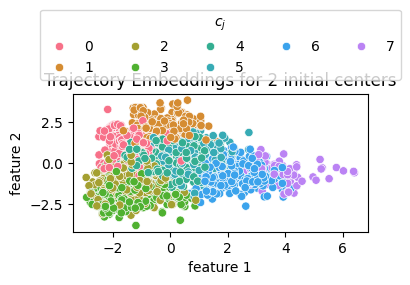

In [7]:
# Perform clustering on Seaquest data
clusters_seaquest, _ = perform_clustering_and_plot(trajectory_embedding_seaquest.detach().cpu().numpy(), 2, 8, ccore=True, plot=True)

In [8]:
 # Train Seaquest model with DiscreteSAC
print('#' * 100)
print("Training Seaquest with DiscreteSAC...")
list_episodes_sq = make_episodes(final_obs_sq, final_act_sq, final_rew_sq, 4)
print(list_episodes_sq[0])
sac_sq = fit_discrete_sac(list_episodes_sq, n_steps=1000, n_steps_per_epoch=100, device=device)

####################################################################################################
Training Seaquest with DiscreteSAC...
2024-04-11 14:42:21 [debug    ] RandomIterator is selected.   
2024-04-11 14:42:21 [info     ] Directory is created at d3rlpy_logs\DiscreteSAC_20240411144221
2024-04-11 14:42:21 [debug    ] Fitting scaler...              scaler=pixel
2024-04-11 14:42:21 [debug    ] Building models...            
2024-04-11 14:42:22 [debug    ] Models have been built.       
2024-04-11 14:42:22 [info     ] Parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144221\params.json params={'action_scaler': None, 'actor_encoder_factory': {'type': 'custom', 'params': {'feature_size': 128}}, 'actor_learning_rate': 0.0003, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 0.0001, 'weight_decay': 0, 'amsgrad': False}, 'batch_size': 256, 'critic_encoder_factory': {'type': 'custom', 'params': {'feature_size': 128}}, 'critic_learning_rate': 0.0003, 'cr

Epoch 1/10: 100%|██████████| 100/100 [00:26<00:00,  3.76it/s, temp_loss=0.0269, temp=0.986, critic_loss=0.259, actor_loss=-2.5]


2024-04-11 14:42:48 [info     ] DiscreteSAC_20240411144221: epoch=1 step=100 epoch=1 metrics={'time_sample_batch': 0.005236306190490723, 'time_algorithm_update': 0.25934821605682373, 'temp_loss': 0.026905361898243427, 'temp': 0.9850741821527481, 'critic_loss': 0.2437521293386817, 'actor_loss': -2.508710662126541, 'time_step': 0.26472737550735476} step=100
2024-04-11 14:42:48 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144221\model_100.pt


Epoch 2/10: 100%|██████████| 100/100 [00:27<00:00,  3.62it/s, temp_loss=0.0265, temp=0.957, critic_loss=0.0807, actor_loss=-2.61]


2024-04-11 14:43:16 [info     ] DiscreteSAC_20240411144221: epoch=2 step=200 epoch=2 metrics={'time_sample_batch': 0.005348947048187256, 'time_algorithm_update': 0.2695033311843872, 'temp_loss': 0.026468987427651882, 'temp': 0.9561156100034713, 'critic_loss': 0.08051263980567455, 'actor_loss': -2.6029686951637268, 'time_step': 0.2750474786758423} step=200
2024-04-11 14:43:16 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144221\model_200.pt


Epoch 3/10: 100%|██████████| 100/100 [00:27<00:00,  3.64it/s, temp_loss=0.0258, temp=0.93, critic_loss=0.0788, actor_loss=-2.52]


2024-04-11 14:43:44 [info     ] DiscreteSAC_20240411144221: epoch=3 step=300 epoch=3 metrics={'time_sample_batch': 0.0052953028678894044, 'time_algorithm_update': 0.2680886101722717, 'temp_loss': 0.025720921438187362, 'temp': 0.9284909760951996, 'critic_loss': 0.07911291809752584, 'actor_loss': -2.5208679032325745, 'time_step': 0.27357962608337405} step=300
2024-04-11 14:43:44 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144221\model_300.pt


Epoch 4/10: 100%|██████████| 100/100 [00:26<00:00,  3.76it/s, temp_loss=0.025, temp=0.903, critic_loss=0.0734, actor_loss=-2.46]


2024-04-11 14:44:10 [info     ] DiscreteSAC_20240411144221: epoch=4 step=400 epoch=4 metrics={'time_sample_batch': 0.0052170729637146, 'time_algorithm_update': 0.2592288970947266, 'temp_loss': 0.025000121872872115, 'temp': 0.902072725892067, 'critic_loss': 0.07339238606393338, 'actor_loss': -2.4554129600524903, 'time_step': 0.2646157217025757} step=400
2024-04-11 14:44:10 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144221\model_400.pt


Epoch 5/10: 100%|██████████| 100/100 [00:27<00:00,  3.65it/s, temp_loss=0.0243, temp=0.878, critic_loss=0.0726, actor_loss=-2.39]


2024-04-11 14:44:38 [info     ] DiscreteSAC_20240411144221: epoch=5 step=500 epoch=5 metrics={'time_sample_batch': 0.005454521179199218, 'time_algorithm_update': 0.26731075048446656, 'temp_loss': 0.02428680246695876, 'temp': 0.8767701280117035, 'critic_loss': 0.07255539301782847, 'actor_loss': -2.3859976387023925, 'time_step': 0.2729604434967041} step=500
2024-04-11 14:44:38 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144221\model_500.pt


Epoch 6/10: 100%|██████████| 100/100 [00:27<00:00,  3.65it/s, temp_loss=0.0236, temp=0.854, critic_loss=0.0711, actor_loss=-2.32]


2024-04-11 14:45:05 [info     ] DiscreteSAC_20240411144221: epoch=6 step=600 epoch=6 metrics={'time_sample_batch': 0.0055570220947265625, 'time_algorithm_update': 0.2668942928314209, 'temp_loss': 0.023607106786221264, 'temp': 0.8524998372793198, 'critic_loss': 0.0703865934163332, 'actor_loss': -2.3169614100456237, 'time_step': 0.27264578342437745} step=600
2024-04-11 14:45:05 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144221\model_600.pt


Epoch 7/10: 100%|██████████| 100/100 [00:30<00:00,  3.27it/s, temp_loss=0.023, temp=0.83, critic_loss=0.0686, actor_loss=-2.26] 


2024-04-11 14:45:36 [info     ] DiscreteSAC_20240411144221: epoch=7 step=700 epoch=7 metrics={'time_sample_batch': 0.006099262237548828, 'time_algorithm_update': 0.29816548109054564, 'temp_loss': 0.022975510228425266, 'temp': 0.8291896718740464, 'critic_loss': 0.0684349885955453, 'actor_loss': -2.2557305765151976, 'time_step': 0.3044972848892212} step=700
2024-04-11 14:45:36 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144221\model_700.pt


Epoch 8/10: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s, temp_loss=0.0224, temp=0.808, critic_loss=0.0654, actor_loss=-2.2]


2024-04-11 14:46:05 [info     ] DiscreteSAC_20240411144221: epoch=8 step=800 epoch=8 metrics={'time_sample_batch': 0.005722060203552246, 'time_algorithm_update': 0.2808581614494324, 'temp_loss': 0.022336691599339247, 'temp': 0.8067703521251679, 'critic_loss': 0.06542044596746564, 'actor_loss': -2.195294620990753, 'time_step': 0.28677773237228393} step=800
2024-04-11 14:46:05 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144221\model_800.pt


Epoch 9/10: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s, temp_loss=0.0218, temp=0.786, critic_loss=0.0656, actor_loss=-2.13]


2024-04-11 14:46:33 [info     ] DiscreteSAC_20240411144221: epoch=9 step=900 epoch=9 metrics={'time_sample_batch': 0.005821683406829834, 'time_algorithm_update': 0.27935672760009767, 'temp_loss': 0.021746510602533818, 'temp': 0.7852002483606338, 'critic_loss': 0.06530830647796393, 'actor_loss': -2.1317797827720644, 'time_step': 0.28538147926330565} step=900
2024-04-11 14:46:33 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144221\model_900.pt


Epoch 10/10: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s, temp_loss=0.0212, temp=0.765, critic_loss=0.0611, actor_loss=-2.08]


2024-04-11 14:47:02 [info     ] DiscreteSAC_20240411144221: epoch=10 step=1000 epoch=10 metrics={'time_sample_batch': 0.005741004943847656, 'time_algorithm_update': 0.27941558361053465, 'temp_loss': 0.02116379315033555, 'temp': 0.7644181954860687, 'critic_loss': 0.06074974399060011, 'actor_loss': -2.077778992652893, 'time_step': 0.28536381006240846} step=1000
2024-04-11 14:47:02 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144221\model_1000.pt


In [9]:
# Compute all possible permutations of clusters
feature_size = 128
custom_encoder_actor = CustomCNNFactory(feature_size)
custom_encoder_critic = CustomCNNFactory(feature_size)

model_params_sq = {
    'actor_learning_rate': 3e-4,
    'critic_learning_rate': 3e-4,
    'temp_learning_rate': 3e-4,
    'batch_size': 256,
    'actor_encoder_factory': custom_encoder_actor,
    'critic_encoder_factory': custom_encoder_critic,
    'scaler': 'pixel',
    'use_gpu': True if device == 'cuda' else False
}

In [10]:
# Fit models per cluster for Seaquest data
models_sq, result_data_combinations_sq = fit_per_cluster(
    model=sac_sq, 
    model_class=d3rlpy.algos.DiscreteSAC,
    model_params=model_params_sq,
    data_embedding=trajectory_embedding_seaquest,
    list_episodes=list_episodes_sq,
    clusters=clusters_seaquest,
    trajectory_embedding=trajectory_embedding_seaquest,
    test_observations=test_observation_sq
)

Original model action:  [3]
Original model action value:  [1.0449057]
Passing:  3 1.0449057
Original model action:  [3]
Original model action value:  [1.0444639]
Passing:  3 1.0444639
Original model action:  [3]
Original model action value:  [1.0432258]
Passing:  3 1.0432258
Original model action:  [3]
Original model action value:  [1.0448134]
Passing:  3 1.0448134
Original model action:  [3]
Original model action value:  [1.044012]
Passing:  3 1.044012
Original model action:  [3]
Original model action value:  [1.0463351]
Passing:  3 1.0463351
Original model action:  [3]
Original model action value:  [1.0443883]
Passing:  3 1.0443883
Original model action:  [3]
Original model action value:  [1.0473814]
Passing:  3 1.0473814
Original model action:  [3]
Original model action value:  [1.0449057]
Passing:  3 1.0449057
----------------------------------------------------------------------------------------------------
Cluster 1 has 248 trajectories out of 2124
------------------------------

Epoch 1/10: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s, temp_loss=0.0275, temp=1, critic_loss=1.71, actor_loss=-1.35]


2024-04-11 14:47:03 [info     ] DiscreteSAC_20240411144702: epoch=1 step=1 epoch=1 metrics={'time_sample_batch': 0.00408625602722168, 'time_algorithm_update': 0.3009004592895508, 'temp_loss': 0.027501767501235008, 'temp': 0.9997011423110962, 'critic_loss': 1.713965654373169, 'actor_loss': -1.3478974103927612, 'time_step': 0.3060719966888428} step=1
2024-04-11 14:47:03 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144702\model_1.pt


Epoch 2/10: 100%|██████████| 1/1 [00:00<00:00,  3.53it/s, temp_loss=0.0276, temp=0.999, critic_loss=1.68, actor_loss=-1.36]


2024-04-11 14:47:03 [info     ] DiscreteSAC_20240411144702: epoch=2 step=2 epoch=2 metrics={'time_sample_batch': 0.0039882659912109375, 'time_algorithm_update': 0.2770051956176758, 'temp_loss': 0.027593055739998817, 'temp': 0.9994023442268372, 'critic_loss': 1.6755282878875732, 'actor_loss': -1.3591355085372925, 'time_step': 0.28208136558532715} step=2
2024-04-11 14:47:03 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144702\model_2.pt


Epoch 3/10: 100%|██████████| 1/1 [00:00<00:00,  3.50it/s, temp_loss=0.0276, temp=0.999, critic_loss=1.64, actor_loss=-1.37]


2024-04-11 14:47:03 [info     ] DiscreteSAC_20240411144702: epoch=3 step=3 epoch=3 metrics={'time_sample_batch': 0.004544973373413086, 'time_algorithm_update': 0.27866101264953613, 'temp_loss': 0.027646347880363464, 'temp': 0.9991036057472229, 'critic_loss': 1.6398398876190186, 'actor_loss': -1.371626853942871, 'time_step': 0.28421688079833984} step=3
2024-04-11 14:47:03 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144702\model_3.pt


Epoch 4/10: 100%|██████████| 1/1 [00:00<00:00,  3.59it/s, temp_loss=0.0277, temp=0.999, critic_loss=1.7, actor_loss=-1.39]


2024-04-11 14:47:04 [info     ] DiscreteSAC_20240411144702: epoch=4 step=4 epoch=4 metrics={'time_sample_batch': 0.004087924957275391, 'time_algorithm_update': 0.2706623077392578, 'temp_loss': 0.02767181023955345, 'temp': 0.9988048672676086, 'critic_loss': 1.7040674686431885, 'actor_loss': -1.3885111808776855, 'time_step': 0.27710723876953125} step=4
2024-04-11 14:47:04 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144702\model_4.pt


Epoch 5/10: 100%|██████████| 1/1 [00:00<00:00,  3.53it/s, temp_loss=0.0277, temp=0.999, critic_loss=1.63, actor_loss=-1.41]


2024-04-11 14:47:04 [info     ] DiscreteSAC_20240411144702: epoch=5 step=5 epoch=5 metrics={'time_sample_batch': 0.004879951477050781, 'time_algorithm_update': 0.27539491653442383, 'temp_loss': 0.027679333463311195, 'temp': 0.9985063076019287, 'critic_loss': 1.634143590927124, 'actor_loss': -1.412050724029541, 'time_step': 0.2822744846343994} step=5
2024-04-11 14:47:04 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144702\model_5.pt


Epoch 6/10: 100%|██████████| 1/1 [00:00<00:00,  3.41it/s, temp_loss=0.0277, temp=0.998, critic_loss=1.57, actor_loss=-1.44]


2024-04-11 14:47:04 [info     ] DiscreteSAC_20240411144702: epoch=6 step=6 epoch=6 metrics={'time_sample_batch': 0.004003286361694336, 'time_algorithm_update': 0.2859039306640625, 'temp_loss': 0.02767256461083889, 'temp': 0.9982077479362488, 'critic_loss': 1.5673627853393555, 'actor_loss': -1.444887399673462, 'time_step': 0.29099249839782715} step=6
2024-04-11 14:47:04 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144702\model_6.pt


Epoch 7/10: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s, temp_loss=0.0276, temp=0.998, critic_loss=1.46, actor_loss=-1.5]


2024-04-11 14:47:05 [info     ] DiscreteSAC_20240411144702: epoch=7 step=7 epoch=7 metrics={'time_sample_batch': 0.004998922348022461, 'time_algorithm_update': 0.26484179496765137, 'temp_loss': 0.027649186551570892, 'temp': 0.9979093074798584, 'critic_loss': 1.4571771621704102, 'actor_loss': -1.4955430030822754, 'time_step': 0.2708399295806885} step=7
2024-04-11 14:47:05 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144702\model_7.pt


Epoch 8/10: 100%|██████████| 1/1 [00:00<00:00,  3.48it/s, temp_loss=0.0276, temp=0.998, critic_loss=1.36, actor_loss=-1.56]


2024-04-11 14:47:05 [info     ] DiscreteSAC_20240411144702: epoch=8 step=8 epoch=8 metrics={'time_sample_batch': 0.004925966262817383, 'time_algorithm_update': 0.279921293258667, 'temp_loss': 0.02760937809944153, 'temp': 0.9976109862327576, 'critic_loss': 1.3613605499267578, 'actor_loss': -1.564590334892273, 'time_step': 0.2859346866607666} step=8
2024-04-11 14:47:05 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144702\model_8.pt


Epoch 9/10: 100%|██████████| 1/1 [00:00<00:00,  3.27it/s, temp_loss=0.0276, temp=0.997, critic_loss=1.24, actor_loss=-1.66]


2024-04-11 14:47:05 [info     ] DiscreteSAC_20240411144702: epoch=9 step=9 epoch=9 metrics={'time_sample_batch': 0.004634380340576172, 'time_algorithm_update': 0.29776453971862793, 'temp_loss': 0.02755003236234188, 'temp': 0.9973128437995911, 'critic_loss': 1.2364181280136108, 'actor_loss': -1.6576485633850098, 'time_step': 0.30457139015197754} step=9
2024-04-11 14:47:05 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144702\model_9.pt


Epoch 10/10: 100%|██████████| 1/1 [00:00<00:00,  3.39it/s, temp_loss=0.0275, temp=0.997, critic_loss=1, actor_loss=-1.78]


2024-04-11 14:47:06 [info     ] DiscreteSAC_20240411144702: epoch=10 step=10 epoch=10 metrics={'time_sample_batch': 0.004136562347412109, 'time_algorithm_update': 0.28894686698913574, 'temp_loss': 0.027468040585517883, 'temp': 0.9970148801803589, 'critic_loss': 1.0018260478973389, 'actor_loss': -1.7811894416809082, 'time_step': 0.2940652370452881} step=10
2024-04-11 14:47:06 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144702\model_10.pt
New model action:  [1]
New model action value:  [0.4836678]
Passing:  1 0.4836678
New model action:  [1]
New model action value:  [0.48403004]
Passing:  1 0.48403004
New model action:  [1]
New model action value:  [0.48453712]
Passing:  1 0.48453712
New model action:  [1]
New model action value:  [0.48262718]
Passing:  1 0.48262718
New model action:  [1]
New model action value:  [0.482615]
Passing:  1 0.482615
New model action:  [1]
New model action value:  [0.48933077]
Passing:  1 0.48933077
New model action:  [1]
New mode

Epoch 1/10: 100%|██████████| 1/1 [00:00<00:00,  3.41it/s, temp_loss=0.0265, temp=1, critic_loss=1.71, actor_loss=-1.39]


2024-04-11 14:47:06 [info     ] DiscreteSAC_20240411144706: epoch=1 step=1 epoch=1 metrics={'time_sample_batch': 0.004045009613037109, 'time_algorithm_update': 0.28690624237060547, 'temp_loss': 0.02651689574122429, 'temp': 0.9997011423110962, 'critic_loss': 1.7077720165252686, 'actor_loss': -1.3881497383117676, 'time_step': 0.2921931743621826} step=1
2024-04-11 14:47:06 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144706\model_1.pt


Epoch 2/10: 100%|██████████| 1/1 [00:00<00:00,  3.29it/s, temp_loss=0.0267, temp=0.999, critic_loss=1.69, actor_loss=-1.4]


2024-04-11 14:47:07 [info     ] DiscreteSAC_20240411144706: epoch=2 step=2 epoch=2 metrics={'time_sample_batch': 0.004029750823974609, 'time_algorithm_update': 0.2965841293334961, 'temp_loss': 0.026724087074398994, 'temp': 0.9994023442268372, 'critic_loss': 1.694669246673584, 'actor_loss': -1.4000879526138306, 'time_step': 0.3026595115661621} step=2
2024-04-11 14:47:07 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144706\model_2.pt


Epoch 3/10: 100%|██████████| 1/1 [00:00<00:00,  3.38it/s, temp_loss=0.0269, temp=0.999, critic_loss=1.65, actor_loss=-1.41]


2024-04-11 14:47:07 [info     ] DiscreteSAC_20240411144706: epoch=3 step=3 epoch=3 metrics={'time_sample_batch': 0.004079341888427734, 'time_algorithm_update': 0.29012060165405273, 'temp_loss': 0.02688750810921192, 'temp': 0.9991035461425781, 'critic_loss': 1.6450477838516235, 'actor_loss': -1.4118800163269043, 'time_step': 0.2952399253845215} step=3
2024-04-11 14:47:07 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144706\model_3.pt


Epoch 4/10: 100%|██████████| 1/1 [00:00<00:00,  3.25it/s, temp_loss=0.027, temp=0.999, critic_loss=1.64, actor_loss=-1.43]


2024-04-11 14:47:07 [info     ] DiscreteSAC_20240411144706: epoch=4 step=4 epoch=4 metrics={'time_sample_batch': 0.004823207855224609, 'time_algorithm_update': 0.3007345199584961, 'temp_loss': 0.02702496200799942, 'temp': 0.9988047480583191, 'critic_loss': 1.6395812034606934, 'actor_loss': -1.4266808032989502, 'time_step': 0.3065054416656494} step=4
2024-04-11 14:47:07 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144706\model_4.pt


Epoch 5/10: 100%|██████████| 1/1 [00:00<00:00,  3.40it/s, temp_loss=0.0271, temp=0.999, critic_loss=1.56, actor_loss=-1.45]


2024-04-11 14:47:08 [info     ] DiscreteSAC_20240411144706: epoch=5 step=5 epoch=5 metrics={'time_sample_batch': 0.006041049957275391, 'time_algorithm_update': 0.285053014755249, 'temp_loss': 0.027137627825140953, 'temp': 0.9985059499740601, 'critic_loss': 1.5569884777069092, 'actor_loss': -1.44614839553833, 'time_step': 0.29311180114746094} step=5
2024-04-11 14:47:08 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144706\model_5.pt


Epoch 6/10: 100%|██████████| 1/1 [00:00<00:00,  3.41it/s, temp_loss=0.0272, temp=0.998, critic_loss=1.56, actor_loss=-1.47]


2024-04-11 14:47:08 [info     ] DiscreteSAC_20240411144706: epoch=6 step=6 epoch=6 metrics={'time_sample_batch': 0.006139278411865234, 'time_algorithm_update': 0.28522205352783203, 'temp_loss': 0.027222497388720512, 'temp': 0.9982070922851562, 'critic_loss': 1.5550569295883179, 'actor_loss': -1.4709912538528442, 'time_step': 0.29260730743408203} step=6
2024-04-11 14:47:08 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144706\model_6.pt


Epoch 7/10: 100%|██████████| 1/1 [00:00<00:00,  3.51it/s, temp_loss=0.0273, temp=0.998, critic_loss=1.45, actor_loss=-1.5]


2024-04-11 14:47:08 [info     ] DiscreteSAC_20240411144706: epoch=7 step=7 epoch=7 metrics={'time_sample_batch': 0.004717826843261719, 'time_algorithm_update': 0.27788710594177246, 'temp_loss': 0.027294348925352097, 'temp': 0.9979082345962524, 'critic_loss': 1.452026128768921, 'actor_loss': -1.5049867630004883, 'time_step': 0.2836911678314209} step=7
2024-04-11 14:47:08 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144706\model_7.pt


Epoch 8/10: 100%|██████████| 1/1 [00:00<00:00,  3.37it/s, temp_loss=0.0273, temp=0.998, critic_loss=1.39, actor_loss=-1.54]


2024-04-11 14:47:09 [info     ] DiscreteSAC_20240411144706: epoch=8 step=8 epoch=8 metrics={'time_sample_batch': 0.006001472473144531, 'time_algorithm_update': 0.28829407691955566, 'temp_loss': 0.027331653982400894, 'temp': 0.9976093173027039, 'critic_loss': 1.3947117328643799, 'actor_loss': -1.5405259132385254, 'time_step': 0.29538941383361816} step=8
2024-04-11 14:47:09 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144706\model_8.pt


Epoch 9/10: 100%|██████████| 1/1 [00:00<00:00,  3.46it/s, temp_loss=0.0273, temp=0.997, critic_loss=1.32, actor_loss=-1.59]


2024-04-11 14:47:09 [info     ] DiscreteSAC_20240411144706: epoch=9 step=9 epoch=9 metrics={'time_sample_batch': 0.003681182861328125, 'time_algorithm_update': 0.28197169303894043, 'temp_loss': 0.02733192779123783, 'temp': 0.9973104596138, 'critic_loss': 1.3189910650253296, 'actor_loss': -1.5914186239242554, 'time_step': 0.2878272533416748} step=9
2024-04-11 14:47:09 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144706\model_9.pt


Epoch 10/10: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s, temp_loss=0.0273, temp=0.997, critic_loss=1.18, actor_loss=-1.66]


2024-04-11 14:47:09 [info     ] DiscreteSAC_20240411144706: epoch=10 step=10 epoch=10 metrics={'time_sample_batch': 0.004555940628051758, 'time_algorithm_update': 0.29782724380493164, 'temp_loss': 0.027265440672636032, 'temp': 0.997011661529541, 'critic_loss': 1.1811785697937012, 'actor_loss': -1.6579501628875732, 'time_step': 0.30442357063293457} step=10
2024-04-11 14:47:09 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144706\model_10.pt
New model action:  [0]
New model action value:  [0.41979963]
Passing:  0 0.41979963
New model action:  [0]
New model action value:  [0.41979995]
Passing:  0 0.41979995
New model action:  [0]
New model action value:  [0.4196803]
Passing:  0 0.4196803
New model action:  [0]
New model action value:  [0.41858715]
Passing:  0 0.41858715
New model action:  [0]
New model action value:  [0.41863286]
Passing:  0 0.41863286
New model action:  [0]
New model action value:  [0.42230642]
Passing:  0 0.42230642
New model action:  [0]
New 

Epoch 1/10: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s, temp_loss=0.0277, temp=1, critic_loss=1.65, actor_loss=-1.37]


2024-04-11 14:47:10 [info     ] DiscreteSAC_20240411144709: epoch=1 step=1 epoch=1 metrics={'time_sample_batch': 0.003998517990112305, 'time_algorithm_update': 0.30637121200561523, 'temp_loss': 0.027699586004018784, 'temp': 0.9997011423110962, 'critic_loss': 1.6512832641601562, 'actor_loss': -1.3652790784835815, 'time_step': 0.31245899200439453} step=1
2024-04-11 14:47:10 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144709\model_1.pt


Epoch 2/10: 100%|██████████| 1/1 [00:00<00:00,  3.23it/s, temp_loss=0.0277, temp=0.999, critic_loss=1.62, actor_loss=-1.39]


2024-04-11 14:47:10 [info     ] DiscreteSAC_20240411144709: epoch=2 step=2 epoch=2 metrics={'time_sample_batch': 0.004006624221801758, 'time_algorithm_update': 0.303206205368042, 'temp_loss': 0.027679260820150375, 'temp': 0.9994023442268372, 'critic_loss': 1.618452548980713, 'actor_loss': -1.387466549873352, 'time_step': 0.30829954147338867} step=2
2024-04-11 14:47:10 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144709\model_2.pt


Epoch 3/10: 100%|██████████| 1/1 [00:00<00:00,  3.46it/s, temp_loss=0.0276, temp=0.999, critic_loss=1.55, actor_loss=-1.42]


2024-04-11 14:47:10 [info     ] DiscreteSAC_20240411144709: epoch=3 step=3 epoch=3 metrics={'time_sample_batch': 0.004614830017089844, 'time_algorithm_update': 0.28222107887268066, 'temp_loss': 0.02763473615050316, 'temp': 0.9991036653518677, 'critic_loss': 1.5501165390014648, 'actor_loss': -1.417030930519104, 'time_step': 0.28783416748046875} step=3
2024-04-11 14:47:10 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144709\model_3.pt


Epoch 4/10: 100%|██████████| 1/1 [00:00<00:00,  3.45it/s, temp_loss=0.0276, temp=0.999, critic_loss=1.6, actor_loss=-1.46]


2024-04-11 14:47:11 [info     ] DiscreteSAC_20240411144709: epoch=4 step=4 epoch=4 metrics={'time_sample_batch': 0.004957675933837891, 'time_algorithm_update': 0.28307652473449707, 'temp_loss': 0.02757233940064907, 'temp': 0.9988051056861877, 'critic_loss': 1.5954387187957764, 'actor_loss': -1.4564108848571777, 'time_step': 0.28972911834716797} step=4
2024-04-11 14:47:11 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144709\model_4.pt


Epoch 5/10: 100%|██████████| 1/1 [00:00<00:00,  3.43it/s, temp_loss=0.0275, temp=0.999, critic_loss=1.54, actor_loss=-1.51]


2024-04-11 14:47:11 [info     ] DiscreteSAC_20240411144709: epoch=5 step=5 epoch=5 metrics={'time_sample_batch': 0.0051043033599853516, 'time_algorithm_update': 0.2826271057128906, 'temp_loss': 0.027499210089445114, 'temp': 0.9985067248344421, 'critic_loss': 1.5355074405670166, 'actor_loss': -1.5087251663208008, 'time_step': 0.29000163078308105} step=5
2024-04-11 14:47:11 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144709\model_5.pt


Epoch 6/10: 100%|██████████| 1/1 [00:00<00:00,  3.27it/s, temp_loss=0.0274, temp=0.998, critic_loss=1.43, actor_loss=-1.56]


2024-04-11 14:47:11 [info     ] DiscreteSAC_20240411144709: epoch=6 step=6 epoch=6 metrics={'time_sample_batch': 0.0036351680755615234, 'time_algorithm_update': 0.297926664352417, 'temp_loss': 0.027416955679655075, 'temp': 0.9982085227966309, 'critic_loss': 1.4271939992904663, 'actor_loss': -1.5609588623046875, 'time_step': 0.30374836921691895} step=6
2024-04-11 14:47:11 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144709\model_6.pt


Epoch 7/10: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s, temp_loss=0.0273, temp=0.998, critic_loss=1.33, actor_loss=-1.62]


2024-04-11 14:47:12 [info     ] DiscreteSAC_20240411144709: epoch=7 step=7 epoch=7 metrics={'time_sample_batch': 0.006579875946044922, 'time_algorithm_update': 0.30254316329956055, 'temp_loss': 0.02730450965464115, 'temp': 0.9979104399681091, 'critic_loss': 1.3303941488265991, 'actor_loss': -1.6162540912628174, 'time_step': 0.31211256980895996} step=7
2024-04-11 14:47:12 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144709\model_7.pt


Epoch 8/10: 100%|██████████| 1/1 [00:00<00:00,  3.20it/s, temp_loss=0.0271, temp=0.998, critic_loss=1.12, actor_loss=-1.68]


2024-04-11 14:47:12 [info     ] DiscreteSAC_20240411144709: epoch=8 step=8 epoch=8 metrics={'time_sample_batch': 0.005213737487792969, 'time_algorithm_update': 0.30483436584472656, 'temp_loss': 0.02714362181723118, 'temp': 0.997612714767456, 'critic_loss': 1.1245338916778564, 'actor_loss': -1.6773346662521362, 'time_step': 0.31113386154174805} step=8
2024-04-11 14:47:12 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144709\model_8.pt


Epoch 9/10: 100%|██████████| 1/1 [00:00<00:00,  3.25it/s, temp_loss=0.0269, temp=0.997, critic_loss=1.02, actor_loss=-1.76]


2024-04-11 14:47:13 [info     ] DiscreteSAC_20240411144709: epoch=9 step=9 epoch=9 metrics={'time_sample_batch': 0.00503849983215332, 'time_algorithm_update': 0.29965710639953613, 'temp_loss': 0.026897020637989044, 'temp': 0.9973152875900269, 'critic_loss': 1.0209882259368896, 'actor_loss': -1.7643052339553833, 'time_step': 0.30643224716186523} step=9
2024-04-11 14:47:13 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144709\model_9.pt


Epoch 10/10: 100%|██████████| 1/1 [00:00<00:00,  3.40it/s, temp_loss=0.0265, temp=0.997, critic_loss=0.732, actor_loss=-1.88]


2024-04-11 14:47:13 [info     ] DiscreteSAC_20240411144709: epoch=10 step=10 epoch=10 metrics={'time_sample_batch': 0.005684852600097656, 'time_algorithm_update': 0.28508472442626953, 'temp_loss': 0.026530830189585686, 'temp': 0.9970183968544006, 'critic_loss': 0.7315219044685364, 'actor_loss': -1.875280737876892, 'time_step': 0.2927703857421875} step=10
2024-04-11 14:47:13 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144709\model_10.pt
New model action:  [3]
New model action value:  [0.8765696]
Passing:  3 0.8765696
New model action:  [3]
New model action value:  [0.876724]
Passing:  3 0.876724
New model action:  [3]
New model action value:  [0.8770921]
Passing:  3 0.8770921
New model action:  [3]
New model action value:  [0.8729143]
Passing:  3 0.8729143
New model action:  [3]
New model action value:  [0.8730658]
Passing:  3 0.8730658
New model action:  [3]
New model action value:  [0.8840109]
Passing:  3 0.8840109
New model action:  [3]
New model action 

Epoch 1/10: 100%|██████████| 1/1 [00:00<00:00,  3.33it/s, temp_loss=0.0273, temp=1, critic_loss=1.63, actor_loss=-1.36]


2024-04-11 14:47:13 [info     ] DiscreteSAC_20240411144713: epoch=1 step=1 epoch=1 metrics={'time_sample_batch': 0.0030472278594970703, 'time_algorithm_update': 0.29479146003723145, 'temp_loss': 0.027283351868391037, 'temp': 0.9997011423110962, 'critic_loss': 1.6343514919281006, 'actor_loss': -1.364832878112793, 'time_step': 0.29887986183166504} step=1
2024-04-11 14:47:13 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144713\model_1.pt


Epoch 2/10: 100%|██████████| 1/1 [00:00<00:00,  3.36it/s, temp_loss=0.0275, temp=0.999, critic_loss=1.67, actor_loss=-1.37]


2024-04-11 14:47:14 [info     ] DiscreteSAC_20240411144713: epoch=2 step=2 epoch=2 metrics={'time_sample_batch': 0.004007816314697266, 'time_algorithm_update': 0.290844202041626, 'temp_loss': 0.02746715396642685, 'temp': 0.9994023442268372, 'critic_loss': 1.6656383275985718, 'actor_loss': -1.373946189880371, 'time_step': 0.29538631439208984} step=2
2024-04-11 14:47:14 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144713\model_2.pt


Epoch 3/10: 100%|██████████| 1/1 [00:00<00:00,  3.30it/s, temp_loss=0.0275, temp=0.999, critic_loss=1.63, actor_loss=-1.38]


2024-04-11 14:47:14 [info     ] DiscreteSAC_20240411144713: epoch=3 step=3 epoch=3 metrics={'time_sample_batch': 0.004380702972412109, 'time_algorithm_update': 0.29698967933654785, 'temp_loss': 0.0275455079972744, 'temp': 0.9991035461425781, 'critic_loss': 1.6305818557739258, 'actor_loss': -1.3841843605041504, 'time_step': 0.3024559020996094} step=3
2024-04-11 14:47:14 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144713\model_3.pt


Epoch 4/10: 100%|██████████| 1/1 [00:00<00:00,  3.27it/s, temp_loss=0.0276, temp=0.999, critic_loss=1.62, actor_loss=-1.4]


2024-04-11 14:47:14 [info     ] DiscreteSAC_20240411144713: epoch=4 step=4 epoch=4 metrics={'time_sample_batch': 0.00409698486328125, 'time_algorithm_update': 0.2985408306121826, 'temp_loss': 0.027556587010622025, 'temp': 0.9988048076629639, 'critic_loss': 1.621436357498169, 'actor_loss': -1.397847294807434, 'time_step': 0.3047606945037842} step=4
2024-04-11 14:47:14 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144713\model_4.pt


Epoch 5/10: 100%|██████████| 1/1 [00:00<00:00,  3.44it/s, temp_loss=0.0275, temp=0.999, critic_loss=1.51, actor_loss=-1.42]


2024-04-11 14:47:15 [info     ] DiscreteSAC_20240411144713: epoch=5 step=5 epoch=5 metrics={'time_sample_batch': 0.0046062469482421875, 'time_algorithm_update': 0.2826499938964844, 'temp_loss': 0.027521828189492226, 'temp': 0.9985061883926392, 'critic_loss': 1.5074580907821655, 'actor_loss': -1.416479468345642, 'time_step': 0.2883765697479248} step=5
2024-04-11 14:47:15 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144713\model_5.pt


Epoch 6/10: 100%|██████████| 1/1 [00:00<00:00,  3.38it/s, temp_loss=0.0274, temp=0.998, critic_loss=1.54, actor_loss=-1.44]


2024-04-11 14:47:15 [info     ] DiscreteSAC_20240411144713: epoch=6 step=6 epoch=6 metrics={'time_sample_batch': 0.004073381423950195, 'time_algorithm_update': 0.2890584468841553, 'temp_loss': 0.027442630380392075, 'temp': 0.998207688331604, 'critic_loss': 1.5384210348129272, 'actor_loss': -1.4429816007614136, 'time_step': 0.29509663581848145} step=6
2024-04-11 14:47:15 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144713\model_6.pt


Epoch 7/10: 100%|██████████| 1/1 [00:00<00:00,  3.18it/s, temp_loss=0.0273, temp=0.998, critic_loss=1.48, actor_loss=-1.48]


2024-04-11 14:47:15 [info     ] DiscreteSAC_20240411144713: epoch=7 step=7 epoch=7 metrics={'time_sample_batch': 0.004997968673706055, 'time_algorithm_update': 0.3044426441192627, 'temp_loss': 0.027328485623002052, 'temp': 0.9979093670845032, 'critic_loss': 1.4768002033233643, 'actor_loss': -1.4799859523773193, 'time_step': 0.31038856506347656} step=7
2024-04-11 14:47:15 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144713\model_7.pt


Epoch 8/10: 100%|██████████| 1/1 [00:00<00:00,  3.37it/s, temp_loss=0.0272, temp=0.998, critic_loss=1.37, actor_loss=-1.53]


2024-04-11 14:47:16 [info     ] DiscreteSAC_20240411144713: epoch=8 step=8 epoch=8 metrics={'time_sample_batch': 0.004695415496826172, 'time_algorithm_update': 0.2880895137786865, 'temp_loss': 0.027178466320037842, 'temp': 0.9976112842559814, 'critic_loss': 1.3715935945510864, 'actor_loss': -1.5317039489746094, 'time_step': 0.2953171730041504} step=8
2024-04-11 14:47:16 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144713\model_8.pt


Epoch 9/10: 100%|██████████| 1/1 [00:00<00:00,  3.54it/s, temp_loss=0.027, temp=0.997, critic_loss=1.28, actor_loss=-1.6]


2024-04-11 14:47:16 [info     ] DiscreteSAC_20240411144713: epoch=9 step=9 epoch=9 metrics={'time_sample_batch': 0.0039904117584228516, 'time_algorithm_update': 0.2758972644805908, 'temp_loss': 0.027003789320588112, 'temp': 0.9973134994506836, 'critic_loss': 1.2836017608642578, 'actor_loss': -1.602798581123352, 'time_step': 0.28098130226135254} step=9
2024-04-11 14:47:16 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144713\model_9.pt


Epoch 10/10: 100%|██████████| 1/1 [00:00<00:00,  3.58it/s, temp_loss=0.0268, temp=0.997, critic_loss=1.13, actor_loss=-1.7]


2024-04-11 14:47:16 [info     ] DiscreteSAC_20240411144713: epoch=10 step=10 epoch=10 metrics={'time_sample_batch': 0.00444793701171875, 'time_algorithm_update': 0.27171897888183594, 'temp_loss': 0.026804322376847267, 'temp': 0.9970160722732544, 'critic_loss': 1.13218355178833, 'actor_loss': -1.6998200416564941, 'time_step': 0.27820348739624023} step=10
2024-04-11 14:47:16 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144713\model_10.pt
New model action:  [0]
New model action value:  [0.43070665]
Passing:  0 0.43070665
New model action:  [0]
New model action value:  [0.43090087]
Passing:  0 0.43090087
New model action:  [0]
New model action value:  [0.4309712]
Passing:  0 0.4309712
New model action:  [0]
New model action value:  [0.4284572]
Passing:  0 0.4284572
New model action:  [0]
New model action value:  [0.42861867]
Passing:  0 0.42861867
New model action:  [0]
New model action value:  [0.434152]
Passing:  0 0.434152
New model action:  [0]
New model ac

Epoch 1/10: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s, temp_loss=0.0275, temp=1, critic_loss=1.66, actor_loss=-1.35]


2024-04-11 14:47:17 [info     ] DiscreteSAC_20240411144717: epoch=1 step=1 epoch=1 metrics={'time_sample_batch': 0.0042841434478759766, 'time_algorithm_update': 0.32256150245666504, 'temp_loss': 0.027511481195688248, 'temp': 0.9997011423110962, 'critic_loss': 1.6562151908874512, 'actor_loss': -1.3543294668197632, 'time_step': 0.3288881778717041} step=1
2024-04-11 14:47:17 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144717\model_1.pt


Epoch 2/10: 100%|██████████| 1/1 [00:00<00:00,  3.18it/s, temp_loss=0.0276, temp=0.999, critic_loss=1.62, actor_loss=-1.37]


2024-04-11 14:47:17 [info     ] DiscreteSAC_20240411144717: epoch=2 step=2 epoch=2 metrics={'time_sample_batch': 0.004968881607055664, 'time_algorithm_update': 0.30735158920288086, 'temp_loss': 0.027590453624725342, 'temp': 0.9994023442268372, 'critic_loss': 1.6154038906097412, 'actor_loss': -1.3674808740615845, 'time_step': 0.3133718967437744} step=2
2024-04-11 14:47:17 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144717\model_2.pt


Epoch 3/10: 100%|██████████| 1/1 [00:00<00:00,  3.22it/s, temp_loss=0.0276, temp=0.999, critic_loss=1.63, actor_loss=-1.38]


2024-04-11 14:47:18 [info     ] DiscreteSAC_20240411144717: epoch=3 step=3 epoch=3 metrics={'time_sample_batch': 0.004994392395019531, 'time_algorithm_update': 0.3035702705383301, 'temp_loss': 0.027563052251935005, 'temp': 0.9991036057472229, 'critic_loss': 1.6277174949645996, 'actor_loss': -1.3824357986450195, 'time_step': 0.3096456527709961} step=3
2024-04-11 14:47:18 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144717\model_3.pt


Epoch 4/10: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s, temp_loss=0.0275, temp=0.999, critic_loss=1.58, actor_loss=-1.4]


2024-04-11 14:47:18 [info     ] DiscreteSAC_20240411144717: epoch=4 step=4 epoch=4 metrics={'time_sample_batch': 0.005094289779663086, 'time_algorithm_update': 0.28542637825012207, 'temp_loss': 0.027474410831928253, 'temp': 0.998805046081543, 'critic_loss': 1.5794780254364014, 'actor_loss': -1.4013850688934326, 'time_step': 0.29164981842041016} step=4
2024-04-11 14:47:18 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144717\model_4.pt


Epoch 5/10: 100%|██████████| 1/1 [00:00<00:00,  3.41it/s, temp_loss=0.0273, temp=0.999, critic_loss=1.52, actor_loss=-1.43]


2024-04-11 14:47:18 [info     ] DiscreteSAC_20240411144717: epoch=5 step=5 epoch=5 metrics={'time_sample_batch': 0.0052754878997802734, 'time_algorithm_update': 0.2855837345123291, 'temp_loss': 0.027347303926944733, 'temp': 0.9985066056251526, 'critic_loss': 1.5221402645111084, 'actor_loss': -1.4278082847595215, 'time_step': 0.29193973541259766} step=5
2024-04-11 14:47:18 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144717\model_5.pt


Epoch 6/10: 100%|██████████| 1/1 [00:00<00:00,  3.25it/s, temp_loss=0.0272, temp=0.998, critic_loss=1.49, actor_loss=-1.46]


2024-04-11 14:47:19 [info     ] DiscreteSAC_20240411144717: epoch=6 step=6 epoch=6 metrics={'time_sample_batch': 0.004065752029418945, 'time_algorithm_update': 0.30114126205444336, 'temp_loss': 0.02719750441610813, 'temp': 0.9982084631919861, 'critic_loss': 1.4864232540130615, 'actor_loss': -1.462900161743164, 'time_step': 0.30637311935424805} step=6
2024-04-11 14:47:19 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144717\model_6.pt


Epoch 7/10: 100%|██████████| 1/1 [00:00<00:00,  3.29it/s, temp_loss=0.027, temp=0.998, critic_loss=1.35, actor_loss=-1.51]


2024-04-11 14:47:19 [info     ] DiscreteSAC_20240411144717: epoch=7 step=7 epoch=7 metrics={'time_sample_batch': 0.004764556884765625, 'time_algorithm_update': 0.29666805267333984, 'temp_loss': 0.02701609395444393, 'temp': 0.9979105591773987, 'critic_loss': 1.34919273853302, 'actor_loss': -1.5111762285232544, 'time_step': 0.3027336597442627} step=7
2024-04-11 14:47:19 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144717\model_7.pt


Epoch 8/10: 100%|██████████| 1/1 [00:00<00:00,  3.11it/s, temp_loss=0.0268, temp=0.998, critic_loss=1.23, actor_loss=-1.57]


2024-04-11 14:47:19 [info     ] DiscreteSAC_20240411144717: epoch=8 step=8 epoch=8 metrics={'time_sample_batch': 0.005040168762207031, 'time_algorithm_update': 0.31483888626098633, 'temp_loss': 0.0268138125538826, 'temp': 0.9976130127906799, 'critic_loss': 1.2304505109786987, 'actor_loss': -1.5749313831329346, 'time_step': 0.32088804244995117} step=8
2024-04-11 14:47:19 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144717\model_8.pt


Epoch 9/10: 100%|██████████| 1/1 [00:00<00:00,  3.31it/s, temp_loss=0.0266, temp=0.997, critic_loss=1.03, actor_loss=-1.66]


2024-04-11 14:47:20 [info     ] DiscreteSAC_20240411144717: epoch=9 step=9 epoch=9 metrics={'time_sample_batch': 0.005671262741088867, 'time_algorithm_update': 0.29499244689941406, 'temp_loss': 0.02655617892742157, 'temp': 0.9973158240318298, 'critic_loss': 1.0302789211273193, 'actor_loss': -1.661699652671814, 'time_step': 0.30170321464538574} step=9
2024-04-11 14:47:20 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144717\model_9.pt


Epoch 10/10: 100%|██████████| 1/1 [00:00<00:00,  3.48it/s, temp_loss=0.0262, temp=0.997, critic_loss=0.842, actor_loss=-1.78]


2024-04-11 14:47:20 [info     ] DiscreteSAC_20240411144717: epoch=10 step=10 epoch=10 metrics={'time_sample_batch': 0.004122257232666016, 'time_algorithm_update': 0.28034448623657227, 'temp_loss': 0.026200054213404655, 'temp': 0.9970192909240723, 'critic_loss': 0.841791033744812, 'actor_loss': -1.782310128211975, 'time_step': 0.28556060791015625} step=10
2024-04-11 14:47:20 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144717\model_10.pt
New model action:  [0]
New model action value:  [0.6330393]
Passing:  0 0.6330393
New model action:  [0]
New model action value:  [0.63348836]
Passing:  0 0.63348836
New model action:  [0]
New model action value:  [0.6328567]
Passing:  0 0.6328567
New model action:  [0]
New model action value:  [0.62990737]
Passing:  0 0.62990737
New model action:  [0]
New model action value:  [0.6299308]
Passing:  0 0.6299308
New model action:  [0]
New model action value:  [0.6374949]
Passing:  0 0.6374949
New model action:  [0]
New model a

Epoch 1/10: 100%|██████████| 1/1 [00:00<00:00,  3.29it/s, temp_loss=0.0261, temp=1, critic_loss=1.65, actor_loss=-1.38]


2024-04-11 14:47:21 [info     ] DiscreteSAC_20240411144720: epoch=1 step=1 epoch=1 metrics={'time_sample_batch': 0.0048787593841552734, 'time_algorithm_update': 0.29649901390075684, 'temp_loss': 0.026106201112270355, 'temp': 0.999701201915741, 'critic_loss': 1.6545555591583252, 'actor_loss': -1.3781434297561646, 'time_step': 0.3027677536010742} step=1
2024-04-11 14:47:21 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144720\model_1.pt


Epoch 2/10: 100%|██████████| 1/1 [00:00<00:00,  3.08it/s, temp_loss=0.0264, temp=0.999, critic_loss=1.67, actor_loss=-1.39]


2024-04-11 14:47:21 [info     ] DiscreteSAC_20240411144720: epoch=2 step=2 epoch=2 metrics={'time_sample_batch': 0.004410982131958008, 'time_algorithm_update': 0.31656885147094727, 'temp_loss': 0.026361895725131035, 'temp': 0.9994024038314819, 'critic_loss': 1.6731386184692383, 'actor_loss': -1.3883112668991089, 'time_step': 0.322021484375} step=2
2024-04-11 14:47:21 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144720\model_2.pt


Epoch 3/10: 100%|██████████| 1/1 [00:00<00:00,  3.50it/s, temp_loss=0.0265, temp=0.999, critic_loss=1.62, actor_loss=-1.4]


2024-04-11 14:47:21 [info     ] DiscreteSAC_20240411144720: epoch=3 step=3 epoch=3 metrics={'time_sample_batch': 0.004075527191162109, 'time_algorithm_update': 0.27946925163269043, 'temp_loss': 0.02654297649860382, 'temp': 0.9991036057472229, 'critic_loss': 1.6202473640441895, 'actor_loss': -1.3998749256134033, 'time_step': 0.28562140464782715} step=3
2024-04-11 14:47:21 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144720\model_3.pt


Epoch 4/10: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s, temp_loss=0.0267, temp=0.999, critic_loss=1.63, actor_loss=-1.42]


2024-04-11 14:47:22 [info     ] DiscreteSAC_20240411144720: epoch=4 step=4 epoch=4 metrics={'time_sample_batch': 0.005051374435424805, 'time_algorithm_update': 0.29044103622436523, 'temp_loss': 0.026686590164899826, 'temp': 0.9988047480583191, 'critic_loss': 1.6296331882476807, 'actor_loss': -1.4154980182647705, 'time_step': 0.29749202728271484} step=4
2024-04-11 14:47:22 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144720\model_4.pt


Epoch 5/10: 100%|██████████| 1/1 [00:00<00:00,  3.43it/s, temp_loss=0.0268, temp=0.999, critic_loss=1.54, actor_loss=-1.44]


2024-04-11 14:47:22 [info     ] DiscreteSAC_20240411144720: epoch=5 step=5 epoch=5 metrics={'time_sample_batch': 0.00449824333190918, 'time_algorithm_update': 0.2841205596923828, 'temp_loss': 0.026794927194714546, 'temp': 0.9985058903694153, 'critic_loss': 1.5421600341796875, 'actor_loss': -1.4359369277954102, 'time_step': 0.29021263122558594} step=5
2024-04-11 14:47:22 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144720\model_5.pt


Epoch 6/10: 100%|██████████| 1/1 [00:00<00:00,  3.40it/s, temp_loss=0.0268, temp=0.998, critic_loss=1.49, actor_loss=-1.46]


2024-04-11 14:47:22 [info     ] DiscreteSAC_20240411144720: epoch=6 step=6 epoch=6 metrics={'time_sample_batch': 0.0050106048583984375, 'time_algorithm_update': 0.28682947158813477, 'temp_loss': 0.026840273290872574, 'temp': 0.9982070326805115, 'critic_loss': 1.4944883584976196, 'actor_loss': -1.4632152318954468, 'time_step': 0.2933647632598877} step=6
2024-04-11 14:47:22 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144720\model_6.pt


Epoch 7/10: 100%|██████████| 1/1 [00:00<00:00,  3.46it/s, temp_loss=0.0268, temp=0.998, critic_loss=1.37, actor_loss=-1.5]


2024-04-11 14:47:23 [info     ] DiscreteSAC_20240411144720: epoch=7 step=7 epoch=7 metrics={'time_sample_batch': 0.003999471664428711, 'time_algorithm_update': 0.2815699577331543, 'temp_loss': 0.026795079931616783, 'temp': 0.9979082345962524, 'critic_loss': 1.3720743656158447, 'actor_loss': -1.5006283521652222, 'time_step': 0.28667545318603516} step=7
2024-04-11 14:47:23 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144720\model_7.pt


Epoch 8/10: 100%|██████████| 1/1 [00:00<00:00,  3.43it/s, temp_loss=0.0266, temp=0.998, critic_loss=1.29, actor_loss=-1.55]


2024-04-11 14:47:23 [info     ] DiscreteSAC_20240411144720: epoch=8 step=8 epoch=8 metrics={'time_sample_batch': 0.0055654048919677734, 'time_algorithm_update': 0.28325700759887695, 'temp_loss': 0.026598049327731133, 'temp': 0.9976096153259277, 'critic_loss': 1.2908363342285156, 'actor_loss': -1.5507375001907349, 'time_step': 0.29042744636535645} step=8
2024-04-11 14:47:23 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144720\model_8.pt


Epoch 9/10: 100%|██████████| 1/1 [00:00<00:00,  3.39it/s, temp_loss=0.0262, temp=0.997, critic_loss=1.14, actor_loss=-1.61]


2024-04-11 14:47:23 [info     ] DiscreteSAC_20240411144720: epoch=9 step=9 epoch=9 metrics={'time_sample_batch': 0.005084037780761719, 'time_algorithm_update': 0.28818488121032715, 'temp_loss': 0.026181649416685104, 'temp': 0.9973114132881165, 'critic_loss': 1.141421914100647, 'actor_loss': -1.6149336099624634, 'time_step': 0.29428768157958984} step=9
2024-04-11 14:47:23 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144720\model_9.pt


Epoch 10/10: 100%|██████████| 1/1 [00:00<00:00,  3.43it/s, temp_loss=0.0254, temp=0.997, critic_loss=0.927, actor_loss=-1.7]


2024-04-11 14:47:24 [info     ] DiscreteSAC_20240411144720: epoch=10 step=10 epoch=10 metrics={'time_sample_batch': 0.004088878631591797, 'time_algorithm_update': 0.28549933433532715, 'temp_loss': 0.025370055809617043, 'temp': 0.9970139861106873, 'critic_loss': 0.9272118210792542, 'actor_loss': -1.7036893367767334, 'time_step': 0.2906041145324707} step=10
2024-04-11 14:47:24 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144720\model_10.pt
New model action:  [3]
New model action value:  [0.8391217]
Passing:  3 0.8391217
New model action:  [3]
New model action value:  [0.839406]
Passing:  3 0.839406
New model action:  [3]
New model action value:  [0.83878285]
Passing:  3 0.83878285
New model action:  [3]
New model action value:  [0.83643824]
Passing:  3 0.83643824
New model action:  [3]
New model action value:  [0.8364819]
Passing:  3 0.8364819
New model action:  [3]
New model action value:  [0.8468449]
Passing:  3 0.8468449
New model action:  [3]
New model ac

Epoch 1/10: 100%|██████████| 1/1 [00:00<00:00,  3.20it/s, temp_loss=0.0269, temp=1, critic_loss=1.68, actor_loss=-1.39]


2024-04-11 14:47:24 [info     ] DiscreteSAC_20240411144724: epoch=1 step=1 epoch=1 metrics={'time_sample_batch': 0.0035352706909179688, 'time_algorithm_update': 0.3068418502807617, 'temp_loss': 0.02693246677517891, 'temp': 0.9997011423110962, 'critic_loss': 1.6800862550735474, 'actor_loss': -1.3880887031555176, 'time_step': 0.3113822937011719} step=1
2024-04-11 14:47:24 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144724\model_1.pt


Epoch 2/10: 100%|██████████| 1/1 [00:00<00:00,  3.31it/s, temp_loss=0.0271, temp=0.999, critic_loss=1.69, actor_loss=-1.41]


2024-04-11 14:47:24 [info     ] DiscreteSAC_20240411144724: epoch=2 step=2 epoch=2 metrics={'time_sample_batch': 0.004618167877197266, 'time_algorithm_update': 0.29369449615478516, 'temp_loss': 0.02705961838364601, 'temp': 0.9994023442268372, 'critic_loss': 1.6932647228240967, 'actor_loss': -1.4071555137634277, 'time_step': 0.3009481430053711} step=2
2024-04-11 14:47:25 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144724\model_2.pt


Epoch 3/10: 100%|██████████| 1/1 [00:00<00:00,  3.18it/s, temp_loss=0.0271, temp=0.999, critic_loss=1.65, actor_loss=-1.43]


2024-04-11 14:47:25 [info     ] DiscreteSAC_20240411144724: epoch=3 step=3 epoch=3 metrics={'time_sample_batch': 0.0050852298736572266, 'time_algorithm_update': 0.3071765899658203, 'temp_loss': 0.02713046967983246, 'temp': 0.9991036057472229, 'critic_loss': 1.6469228267669678, 'actor_loss': -1.4315900802612305, 'time_step': 0.313338041305542} step=3
2024-04-11 14:47:25 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144724\model_3.pt


Epoch 4/10: 100%|██████████| 1/1 [00:00<00:00,  3.34it/s, temp_loss=0.0272, temp=0.999, critic_loss=1.64, actor_loss=-1.46]


2024-04-11 14:47:25 [info     ] DiscreteSAC_20240411144724: epoch=4 step=4 epoch=4 metrics={'time_sample_batch': 0.0050067901611328125, 'time_algorithm_update': 0.29218363761901855, 'temp_loss': 0.027162237092852592, 'temp': 0.9988049268722534, 'critic_loss': 1.6423614025115967, 'actor_loss': -1.4648774862289429, 'time_step': 0.2982785701751709} step=4
2024-04-11 14:47:25 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144724\model_4.pt


Epoch 5/10: 100%|██████████| 1/1 [00:00<00:00,  3.37it/s, temp_loss=0.0272, temp=0.999, critic_loss=1.51, actor_loss=-1.51]


2024-04-11 14:47:26 [info     ] DiscreteSAC_20240411144724: epoch=5 step=5 epoch=5 metrics={'time_sample_batch': 0.004992246627807617, 'time_algorithm_update': 0.2896125316619873, 'temp_loss': 0.027174025774002075, 'temp': 0.9985063076019287, 'critic_loss': 1.511082410812378, 'actor_loss': -1.512635350227356, 'time_step': 0.2956843376159668} step=5
2024-04-11 14:47:26 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144724\model_5.pt


Epoch 6/10: 100%|██████████| 1/1 [00:00<00:00,  3.47it/s, temp_loss=0.0272, temp=0.998, critic_loss=1.47, actor_loss=-1.57]


2024-04-11 14:47:26 [info     ] DiscreteSAC_20240411144724: epoch=6 step=6 epoch=6 metrics={'time_sample_batch': 0.005004167556762695, 'time_algorithm_update': 0.280881404876709, 'temp_loss': 0.02716919407248497, 'temp': 0.9982077479362488, 'critic_loss': 1.4666693210601807, 'actor_loss': -1.5724732875823975, 'time_step': 0.28687453269958496} step=6
2024-04-11 14:47:26 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144724\model_6.pt


Epoch 7/10: 100%|██████████| 1/1 [00:00<00:00,  3.44it/s, temp_loss=0.0272, temp=0.998, critic_loss=1.33, actor_loss=-1.65]


2024-04-11 14:47:26 [info     ] DiscreteSAC_20240411144724: epoch=7 step=7 epoch=7 metrics={'time_sample_batch': 0.00429844856262207, 'time_algorithm_update': 0.2845723628997803, 'temp_loss': 0.027158115059137344, 'temp': 0.9979093074798584, 'critic_loss': 1.3251910209655762, 'actor_loss': -1.6514428853988647, 'time_step': 0.28990650177001953} step=7
2024-04-11 14:47:26 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144724\model_7.pt


Epoch 8/10: 100%|██████████| 1/1 [00:00<00:00,  3.49it/s, temp_loss=0.0272, temp=0.998, critic_loss=1.2, actor_loss=-1.76]


2024-04-11 14:47:26 [info     ] DiscreteSAC_20240411144724: epoch=8 step=8 epoch=8 metrics={'time_sample_batch': 0.00493621826171875, 'time_algorithm_update': 0.27820754051208496, 'temp_loss': 0.02715093083679676, 'temp': 0.9976109266281128, 'critic_loss': 1.199468970298767, 'actor_loss': -1.7611815929412842, 'time_step': 0.2853116989135742} step=8
2024-04-11 14:47:27 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144724\model_8.pt


Epoch 9/10: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s, temp_loss=0.0272, temp=0.997, critic_loss=0.975, actor_loss=-1.89]


2024-04-11 14:47:27 [info     ] DiscreteSAC_20240411144724: epoch=9 step=9 epoch=9 metrics={'time_sample_batch': 0.004494190216064453, 'time_algorithm_update': 0.2994241714477539, 'temp_loss': 0.027155805379152298, 'temp': 0.9973126649856567, 'critic_loss': 0.9754509329795837, 'actor_loss': -1.891980528831482, 'time_step': 0.30582404136657715} step=9
2024-04-11 14:47:27 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144724\model_9.pt


Epoch 10/10: 100%|██████████| 1/1 [00:00<00:00,  3.40it/s, temp_loss=0.0272, temp=0.997, critic_loss=0.734, actor_loss=-2.08]


2024-04-11 14:47:27 [info     ] DiscreteSAC_20240411144724: epoch=10 step=10 epoch=10 metrics={'time_sample_batch': 0.005306720733642578, 'time_algorithm_update': 0.28572988510131836, 'temp_loss': 0.027156881988048553, 'temp': 0.9970144629478455, 'critic_loss': 0.7338911294937134, 'actor_loss': -2.082740545272827, 'time_step': 0.2921268939971924} step=10
2024-04-11 14:47:27 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144724\model_10.pt
New model action:  [0]
New model action value:  [0.8642442]
Passing:  0 0.8642442
New model action:  [0]
New model action value:  [0.8636608]
Passing:  0 0.8636608
New model action:  [0]
New model action value:  [0.86381507]
Passing:  0 0.86381507
New model action:  [0]
New model action value:  [0.85965335]
Passing:  0 0.85965335
New model action:  [0]
New model action value:  [0.85933805]
Passing:  0 0.85933805
New model action:  [0]
New model action value:  [0.87162817]
Passing:  0 0.87162817
New model action:  [0]
New mod

Epoch 1/10: 100%|██████████| 1/1 [00:00<00:00,  3.18it/s, temp_loss=0.0257, temp=1, critic_loss=1.68, actor_loss=-1.37]


2024-04-11 14:47:28 [info     ] DiscreteSAC_20240411144727: epoch=1 step=1 epoch=1 metrics={'time_sample_batch': 0.003976106643676758, 'time_algorithm_update': 0.30800485610961914, 'temp_loss': 0.025707561522722244, 'temp': 0.999701201915741, 'critic_loss': 1.677969217300415, 'actor_loss': -1.3677513599395752, 'time_step': 0.31308555603027344} step=1
2024-04-11 14:47:28 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144727\model_1.pt


Epoch 2/10: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s, temp_loss=0.026, temp=0.999, critic_loss=1.67, actor_loss=-1.38]


2024-04-11 14:47:28 [info     ] DiscreteSAC_20240411144727: epoch=2 step=2 epoch=2 metrics={'time_sample_batch': 0.0039920806884765625, 'time_algorithm_update': 0.3259754180908203, 'temp_loss': 0.02597017027437687, 'temp': 0.9994024038314819, 'critic_loss': 1.668217420578003, 'actor_loss': -1.3772437572479248, 'time_step': 0.33138179779052734} step=2
2024-04-11 14:47:28 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144727\model_2.pt


Epoch 3/10: 100%|██████████| 1/1 [00:00<00:00,  3.33it/s, temp_loss=0.0262, temp=0.999, critic_loss=1.62, actor_loss=-1.39]


2024-04-11 14:47:28 [info     ] DiscreteSAC_20240411144727: epoch=3 step=3 epoch=3 metrics={'time_sample_batch': 0.0039081573486328125, 'time_algorithm_update': 0.29421234130859375, 'temp_loss': 0.026186320930719376, 'temp': 0.9991036057472229, 'critic_loss': 1.6230249404907227, 'actor_loss': -1.3871557712554932, 'time_step': 0.2992126941680908} step=3
2024-04-11 14:47:28 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144727\model_3.pt


Epoch 4/10: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s, temp_loss=0.0264, temp=0.999, critic_loss=1.62, actor_loss=-1.4]


2024-04-11 14:47:29 [info     ] DiscreteSAC_20240411144727: epoch=4 step=4 epoch=4 metrics={'time_sample_batch': 0.0056383609771728516, 'time_algorithm_update': 0.2897522449493408, 'temp_loss': 0.026356922462582588, 'temp': 0.9988047480583191, 'critic_loss': 1.617175817489624, 'actor_loss': -1.3997944593429565, 'time_step': 0.2975296974182129} step=4
2024-04-11 14:47:29 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144727\model_4.pt


Epoch 5/10: 100%|██████████| 1/1 [00:00<00:00,  3.06it/s, temp_loss=0.0265, temp=0.999, critic_loss=1.57, actor_loss=-1.42]


2024-04-11 14:47:29 [info     ] DiscreteSAC_20240411144727: epoch=5 step=5 epoch=5 metrics={'time_sample_batch': 0.006144046783447266, 'time_algorithm_update': 0.3187069892883301, 'temp_loss': 0.026515506207942963, 'temp': 0.9985058307647705, 'critic_loss': 1.5671260356903076, 'actor_loss': -1.4179103374481201, 'time_step': 0.32685184478759766} step=5
2024-04-11 14:47:29 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144727\model_5.pt


Epoch 6/10: 100%|██████████| 1/1 [00:00<00:00,  3.36it/s, temp_loss=0.0266, temp=0.998, critic_loss=1.52, actor_loss=-1.44]


2024-04-11 14:47:29 [info     ] DiscreteSAC_20240411144727: epoch=6 step=6 epoch=6 metrics={'time_sample_batch': 0.005719661712646484, 'time_algorithm_update': 0.2890639305114746, 'temp_loss': 0.026647161692380905, 'temp': 0.9982068538665771, 'critic_loss': 1.5207359790802002, 'actor_loss': -1.4421584606170654, 'time_step': 0.2962944507598877} step=6
2024-04-11 14:47:30 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144727\model_6.pt


Epoch 7/10: 100%|██████████| 1/1 [00:00<00:00,  3.20it/s, temp_loss=0.0268, temp=0.998, critic_loss=1.45, actor_loss=-1.47]


2024-04-11 14:47:30 [info     ] DiscreteSAC_20240411144727: epoch=7 step=7 epoch=7 metrics={'time_sample_batch': 0.00408625602722168, 'time_algorithm_update': 0.3058934211730957, 'temp_loss': 0.026757696643471718, 'temp': 0.997907817363739, 'critic_loss': 1.4506009817123413, 'actor_loss': -1.4745368957519531, 'time_step': 0.31098294258117676} step=7
2024-04-11 14:47:30 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144727\model_7.pt


Epoch 8/10: 100%|██████████| 1/1 [00:00<00:00,  3.29it/s, temp_loss=0.0269, temp=0.998, critic_loss=1.36, actor_loss=-1.52]


2024-04-11 14:47:30 [info     ] DiscreteSAC_20240411144727: epoch=8 step=8 epoch=8 metrics={'time_sample_batch': 0.00600123405456543, 'time_algorithm_update': 0.29474806785583496, 'temp_loss': 0.02687150053679943, 'temp': 0.9976086616516113, 'critic_loss': 1.3643183708190918, 'actor_loss': -1.522875189781189, 'time_step': 0.30283594131469727} step=8
2024-04-11 14:47:30 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144727\model_8.pt


Epoch 9/10: 100%|██████████| 1/1 [00:00<00:00,  3.56it/s, temp_loss=0.0269, temp=0.997, critic_loss=1.22, actor_loss=-1.58]


2024-04-11 14:47:30 [info     ] DiscreteSAC_20240411144727: epoch=9 step=9 epoch=9 metrics={'time_sample_batch': 0.005217552185058594, 'time_algorithm_update': 0.2742037773132324, 'temp_loss': 0.02694464474916458, 'temp': 0.9973094463348389, 'critic_loss': 1.2241065502166748, 'actor_loss': -1.5841444730758667, 'time_step': 0.28057146072387695} step=9
2024-04-11 14:47:31 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144727\model_9.pt


Epoch 10/10: 100%|██████████| 1/1 [00:00<00:00,  3.41it/s, temp_loss=0.027, temp=0.997, critic_loss=1.06, actor_loss=-1.67]


2024-04-11 14:47:31 [info     ] DiscreteSAC_20240411144727: epoch=10 step=10 epoch=10 metrics={'time_sample_batch': 0.005956172943115234, 'time_algorithm_update': 0.2856123447418213, 'temp_loss': 0.026986446231603622, 'temp': 0.9970101714134216, 'critic_loss': 1.0635426044464111, 'actor_loss': -1.6697007417678833, 'time_step': 0.29257655143737793} step=10
2024-04-11 14:47:31 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411144727\model_10.pt
New model action:  [1]
New model action value:  [0.43712604]
Passing:  1 0.43712604
New model action:  [1]
New model action value:  [0.4372452]
Passing:  1 0.4372452
New model action:  [1]
New model action value:  [0.436946]
Passing:  1 0.436946
New model action:  [1]
New model action value:  [0.4357456]
Passing:  1 0.4357456
New model action:  [1]
New model action value:  [0.43595248]
Passing:  1 0.43595248
New model action:  [1]
New model action value:  [0.4415375]
Passing:  1 0.4415375
New model action:  [1]
New model ac

#################################################################################################### Observation 1 ####################################################################################################
(1, 4, 84, 84)
0-th model predicted action: [3]
Original model's action [3]
1-th model predicted action: [1]
Original model's action [3]
Wasserstein distance:  0.0
2-th model predicted action: [0]
Original model's action [3]
Wasserstein distance:  0.0
3-th model predicted action: [3]
Original model's action [3]
4-th model predicted action: [0]
Original model's action [3]
Wasserstein distance:  0.0
5-th model predicted action: [0]
Original model's action [3]
Wasserstein distance:  0.0
6-th model predicted action: [3]
Original model's action [3]
7-th model predicted action: [0]
Original model's action [3]
Wasserstein distance:  0.0
8-th model predicted action: [1]
Original model's action [3]
Wasserstein distance:  0.0
DEBUG: len(sub_dist) 9
DEBUG: sub_dist [1000000000.0, 0.0,

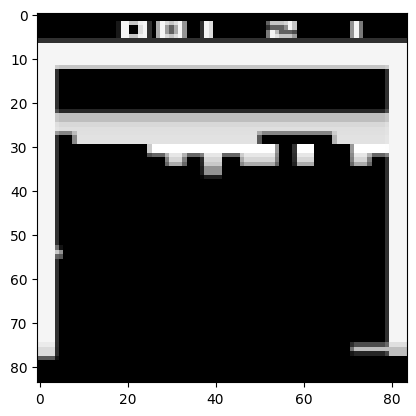

In [11]:
attributions_sq = trajectory_attributions_sq(test_observation_sq, models_sq, trajectory_embedding_seaquest, clusters_seaquest)

In [12]:
# Print table 2 for Seaquest data
print('#' * 100)
print("Print table 2")
print_results_sq(result_data_combinations_sq, test_observation_sq, models_sq, attributions_sq)

####################################################################################################
Print table 2
[1. 0. 0. 1. 0. 0. 1. 0. 0.]
Avg Delta Q
0.0
0.6308183670043945
0.7034923434257507
0.18978466093540192
0.6916403770446777
0.4641213119029999
0.23178286850452423
0.2042042762041092
0.6835449934005737
Data distances


c:\Users\jortv\OneDrive\Bureau\FACT\Explaining-RL-Decisions-with-Trajectories\Breakout\utils.py:442: RuntimeWarning: invalid value encountered in divide
  print((data_distances - data_distances.min()) / (data_distances.max() - data_distances.min()))


[nan nan nan nan nan nan nan nan nan]


c:\Users\jortv\OneDrive\Bureau\FACT\Explaining-RL-Decisions-with-Trajectories\Breakout\utils.py:448: RuntimeWarning: invalid value encountered in divide
  print(cluster_attr_freq/cluster_attr_freq.sum())


[nan nan nan nan nan nan nan nan nan]
